In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
dataDIR = 'short'
DS = xr.open_dataset(dataDIR)

In [3]:
d_t = DS.TAU_OD2D #2d dust

In [4]:
d_t.shape

(240, 36, 72)

In [5]:
tsf = DS.TOASW.values #top solar flux

In [6]:
tsf.shape

(240, 36, 72)

In [7]:
bsf = DS.GSW.values #bottom solar flux, ouput

In [8]:
bsf.shape

(240, 36, 72)

Q_ext and Solar Fraction array:

In [9]:
frac = np.array([[0.572, 0.01053964],
             [0.948, 0.01813533],
             [1.349, 0.03795698],
             [1.799, 0.0934216],
             [2.307, 0.2550174],
             [2.543, 0.46579044],
             [2.562, 2.562]])

In [10]:
d_t7 = []
tsf7 = []
Q_ref = 2.52497935
for i in range(7):
    d_t7.append(np.array(d_t) * frac[i, 0]/Q_ref)
    tsf7.append(np.array(tsf) * frac[i, 1])    
d_t7 = np.array(d_t7)
tsf7 = np.array(tsf7)

In [11]:
exp_d = np.exp(-d_t7) #exponent of dust opacity

In [12]:
flux_sum = 0
for i in range(7):
    flux_sum += exp_d[i] * tsf7[i]

In [13]:
flux_sum[0][0].shape

(72,)

In [14]:
test1 = np.array([[[1,2],[3,4]],[[5,6],[7,8]],[[9,10],[11,12]]])
test1[1]

array([[5, 6],
       [7, 8]])

In [15]:
flux_sum

array([[[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [659.32874, 631.8445 , 604.36035, ..., 739.6997 , 713.4623 ,
         686.6039 ],
        [658.28894, 641.71277, 625.13666, ..., 706.7621 , 690.9379 ,
         674.7391 ],
        [652.2001 , 646.6604 , 641.12085, ..., 668.3994 , 663.11115,
         657.6976 ]],

       [[  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        ...,
        [317.33722, 316.1377 , 317.33902, ..., 335.1588 , 326.88412,
         320.9285 ],
        [451.92206, 451.1986 , 451.92313, ..., 462.6706 , 457.67996,
   

In [16]:
in_flux = flux_sum.flatten().reshape(-1,1)
out_flux = bsf.flatten().reshape(-1,1)

In [17]:
t_flux = np.concatenate((in_flux, out_flux),axis = 1)

In [18]:
t_flux.shape

(622080, 2)

In [19]:
d_flux = pd.DataFrame(t_flux)
d_flux

,0,1
0,0.000000,0.000000
1,0.000000,0.000000
2,0.000000,0.000000
3,0.000000,0.000000
4,0.000000,0.000000
...,...,...
622075,567.198120,96.394714
622076,570.083862,97.255112
622077,572.475586,98.031403
622078,574.355042,98.716751


In [20]:
d_flux_rem0 = d_flux[d_flux.iloc[:,0] != 0]#removes rows with 0 top solar flux
d_flux_rem0

,0,1
409,8.696111,0.563285
410,35.583702,2.558643
411,57.994366,4.861805
412,75.611313,7.064542
413,88.297760,8.831075
...,...,...
622075,567.198120,96.394714
622076,570.083862,97.255112
622077,572.475586,98.031403
622078,574.355042,98.716751


In [21]:
in_f = np.array(d_flux_rem0[0]).reshape(-1,1)
in_f

array([[  8.696111],
       [ 35.583702],
       [ 57.994366],
       ...,
       [572.4756  ],
       [574.35504 ],
       [575.7078  ]], dtype=float32)

In [22]:
out_f = np.array(d_flux_rem0[1]).reshape(-1,1)
out_f

array([[ 0.5632845],
       [ 2.5586426],
       [ 4.861805 ],
       ...,
       [98.0314   ],
       [98.71675  ],
       [99.30495  ]], dtype=float32)

Let's try linear regression

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(in_f, out_f)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
from sklearn.metrics import mean_squared_error

pred_f = lin_reg.predict(in_f) #prediction
lin_mse = mean_squared_error(out_f, pred_f)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

17.104452

In [25]:
err_f = pred_f - out_f

In [26]:
np.max(err_f)

51.205093

In [27]:
rel_f = err_f/out_f

In [28]:
np.max(rel_f)

0.6600446

In [42]:
np.min(rel_f) #that's big...

-122565976.0

In [30]:
lin_reg.coef_ #proportionality between input and output fluxes

array([[0.26946086]], dtype=float32)

This looks pretty good, lets graph the first time snapshot:

In [31]:
indices = np.array(d_flux_rem0.index)#this provides the location of each point according to the date, latitude, longtitude
indices

array([   409,    410,    411, ..., 622077, 622078, 622079], dtype=int64)

In [32]:
pred_contour = np.full((36, 72), np.nan)
out_contour = np.full((36, 72), np.nan)
lat_list = []
long_list = []
indices0 = indices[indices < 36*72]

for i in range(len(indices0)):
    lat_point = indices0[i]//72
    long_point = indices0[i]%72
    lat_list.append(lat_point)
    long_list.append(long_point)
    pred_contour[lat_point][long_point] = pred_f[i]
    out_contour[lat_point][long_point] = out_f[i]  
lat_list = np.array(lat_list)
long_list = np.array(long_list)
  

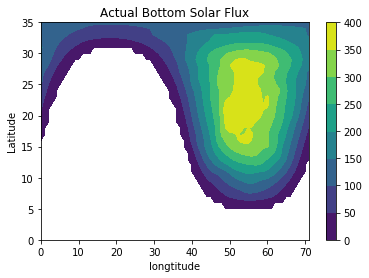

In [33]:
plt.contourf(out_contour)
plt.colorbar()
plt.title("Actual Bottom Solar Flux")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

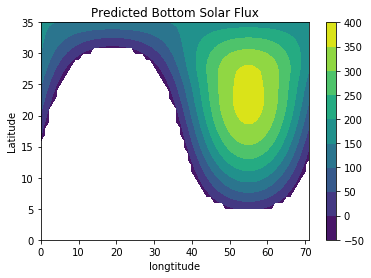

In [34]:
plt.contourf(pred_contour)
plt.colorbar()
plt.title("Predicted Bottom Solar Flux")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

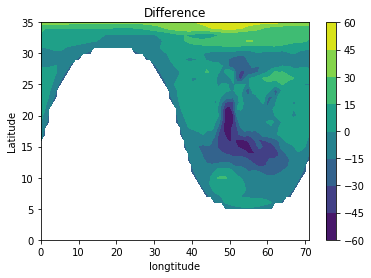

In [35]:
plt.contourf(pred_contour - out_contour)
plt.colorbar()
plt.title("Difference")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

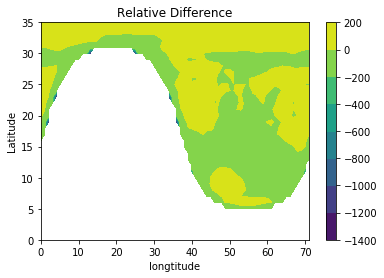

In [36]:
plt.contourf((pred_contour - out_contour)/out_contour)
plt.colorbar()
plt.title("Relative Difference")
plt.xlabel("longtitude")
plt.ylabel("Latitude")
plt.show()

no relative errors greater than 100%:

In [37]:
((pred_contour - out_contour)/out_contour)[((pred_contour - out_contour)/out_contour) > 1] 

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([], dtype=float64)

some big negative relative errors:

In [38]:
((pred_contour - out_contour)/out_contour)[((pred_contour - out_contour)/out_contour) < -1]

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([-3.22038488e+01, -5.03787984e+00, -1.88294267e+00, -1.81935897e+00,
       -4.85008686e+00, -3.21644846e+01, -3.02847845e+01, -2.26783378e+00,
       -2.24614817e+00, -3.03108397e+01, -4.80625582e+01, -1.72984462e+00,
       -1.62120356e+00, -4.65095214e+01, -9.67569618e+00, -9.74141255e+00,
       -8.50055886e+00, -8.61394199e+00, -1.77147369e+01, -1.77108947e+01,
       -3.41285943e+02, -1.21109918e+00, -1.21876279e+00, -3.52222096e+02,
       -3.72164026e+00, -3.86775782e+00, -3.57862662e+01, -3.87117064e+01,
       -2.61745676e+00, -2.76872101e+00, -4.12748339e+01, -3.59555872e+01,
       -3.43062778e+00, -3.09664555e+00, -1.06921365e+02, -9.06328107e+01,
       -5.39552401e+00, -5.05165941e+00, -1.28592367e+03, -1.17416461e+03,
       -8.59968139e+00, -8.16509200e+00, -1.26741975e+00, -1.24766580e+00,
       -9.71211301e+00, -9.37443439e+00, -1.22408744e+00, -1.26983388e+03,
       -1.17362210e+03, -1.20816984e+00, -5.38087145e+00, -5.19001079e+00,
       -2.43140732e+01, -

a few really big negative relative errors:

In [39]:
((pred_contour - out_contour)/out_contour)[((pred_contour - out_contour)/out_contour) < -100]

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([ -341.28594274,  -352.22209578,  -106.92136459, -1285.92367381,
       -1174.16460797, -1269.83387774, -1173.62209798,  -114.49483242,
        -136.78896568,  -116.91237984,  -128.77293166,  -114.98950391,
       -1267.7947722 , -1139.68297764])